<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand.jpg" align="left">
</div>
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - UEBA: Detección de Anomalías</p>
<p style="margin: 0; text-align:right;">20231 - Máster universitario en Ciencias de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicaciones</p>
</div>
</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos:</strong> Alejandro Ortega de los Ríos
</div>

# GENERACIÓN DEL GRAFO DE USUARIOS

A continuación se va a construir un grafo que refleje la interacción de los componentes de una institución. Se emplearán tanto las interacciones sociales (correos), así como la estructura de la propia empresa.

La generación del grafo se hará con las siguientes consideraciones: 
    
    - No dirigido
    - Sin bucles
    - No ponderado

In [1]:
# Librerías básicas
import pandas as pd
import os
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools

## 1. Grafo corporativo

Se va a generar el grafo que refleja la estructura de la organización. Para ello, se van a importar los ficheros del directorio LDAP, que contiene esta información.

In [2]:
# Directorio principal que contiene los subdirectorios
directorio_principal = '..\data\LDAP'

# Lista para almacenar los DataFrames de cada subdirectorio
dataframes = []

# Itero sobre los subdirectorios
for subdir in os.listdir(directorio_principal):
    # Lo el archivo de cada subdirectorio
    archivo = os.path.join(directorio_principal, subdir)

    if os.path.exists(archivo):
        # Cargar el archivo en un DataFrame y agregarlo a la lista
        df = pd.read_csv(archivo)
        dataframes.append(df)

# Combino datasets
ldap_df = pd.concat(dataframes, ignore_index=True)


print("Información del DataFrame resultante:")
print(ldap_df.info())

# Exporto el fichero
ldap_df.to_csv('../data/ldap.csv', index=False)

Información del DataFrame resultante:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16743 entries, 0 to 16742
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   employee_name    16743 non-null  object
 1   user_id          16743 non-null  object
 2   email            16743 non-null  object
 3   role             16743 non-null  object
 4   business_unit    16743 non-null  int64 
 5   functional_unit  16707 non-null  object
 6   department       16491 non-null  object
 7   team             14549 non-null  object
 8   supervisor       16725 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.1+ MB
None


In [3]:
ldap_df.head()

,employee_name,user_id,email,role,business_unit,functional_unit,department,team,supervisor
0,Calvin Edan Love,CEL0561,Calvin.Edan.Love@dtaa.com,ComputerProgrammer,1,2 - ResearchAndEngineering,2 - SoftwareManagement,3 - Software,Stephanie Briar Harrington
1,Christine Reagan Deleon,CRD0624,Christine.Reagan.Deleon@dtaa.com,Salesman,1,5 - SalesAndMarketing,2 - Sales,3 - RegionalSales,Winter Veda Burks
2,Jade Felicia Caldwell,JFC0557,Jade.Felicia.Caldwell@dtaa.com,SoftwareEngineer,1,2 - ResearchAndEngineering,2 - SoftwareManagement,3 - Software,Stephanie Briar Harrington
3,Aquila Stewart Dejesus,ASD0577,Aquila.Stewart.Dejesus@dtaa.com,ProductionLineWorker,1,3 - Manufacturing,3 - Assembly,3 - AssemblyDept,Whilemina Pandora England
4,Micah Abdul Rojas,MAR0955,Micah.Abdul.Rojas@dtaa.com,ProductionLineWorker,1,3 - Manufacturing,3 - Assembly,6 - AssemblyDept,Sandra Beverly Diaz


In [4]:
#Diccionario que relaciona email con user_id
user_email_df = ldap_df[['user_id', 'email']]
user_email = pd.Series(user_email_df['user_id'].values, index=user_email_df['email']).to_dict()

In [5]:
user_email_df.head()

,user_id,email
0,CEL0561,Calvin.Edan.Love@dtaa.com
1,CRD0624,Christine.Reagan.Deleon@dtaa.com
2,JFC0557,Jade.Felicia.Caldwell@dtaa.com
3,ASD0577,Aquila.Stewart.Dejesus@dtaa.com
4,MAR0955,Micah.Abdul.Rojas@dtaa.com


In [6]:
#Diccionario que relaciona user_id con su email
user_email_dict = pd.Series(ldap_df['user_id'].values, index=ldap_df['email']).dropna().to_dict()

In [7]:
#Genero un grafo tomando como nodos los user_id
G1 = nx.Graph()

for email, user_id in user_email_dict.items():
    # Agregar el nodo con el user_id y sus emails como atributo
    G1.add_node(user_id, email=email)

print("Número de nodos: {}".format(G1.number_of_nodes()))

Número de nodos: 1000


In [8]:
#Genero las aristas
supervisors = ldap_df['supervisor'].dropna().unique().tolist()

In [9]:
#Genero diccionario de supervisores junto con su user_id
super_df = ldap_df[ldap_df['employee_name'].isin(supervisors) == True][['employee_name', 'user_id']].drop_duplicates()
super_dict = pd.Series(super_df['user_id'].values, index=super_df['employee_name']).to_dict()

In [10]:
#Amplío el dataset
ldap_df['supervisor_id'] = ldap_df['supervisor'].map(super_dict)

In [11]:
ldap_df.head()

,employee_name,user_id,email,role,business_unit,functional_unit,department,team,supervisor,supervisor_id
0,Calvin Edan Love,CEL0561,Calvin.Edan.Love@dtaa.com,ComputerProgrammer,1,2 - ResearchAndEngineering,2 - SoftwareManagement,3 - Software,Stephanie Briar Harrington,SBH0537
1,Christine Reagan Deleon,CRD0624,Christine.Reagan.Deleon@dtaa.com,Salesman,1,5 - SalesAndMarketing,2 - Sales,3 - RegionalSales,Winter Veda Burks,WVB0539
2,Jade Felicia Caldwell,JFC0557,Jade.Felicia.Caldwell@dtaa.com,SoftwareEngineer,1,2 - ResearchAndEngineering,2 - SoftwareManagement,3 - Software,Stephanie Briar Harrington,SBH0537
3,Aquila Stewart Dejesus,ASD0577,Aquila.Stewart.Dejesus@dtaa.com,ProductionLineWorker,1,3 - Manufacturing,3 - Assembly,3 - AssemblyDept,Whilemina Pandora England,WPE0538
4,Micah Abdul Rojas,MAR0955,Micah.Abdul.Rojas@dtaa.com,ProductionLineWorker,1,3 - Manufacturing,3 - Assembly,6 - AssemblyDept,Sandra Beverly Diaz,SBD0913


In [12]:
#Genero aristas (un supervisor_id es Nan)
for index, row in ldap_df[['user_id', 'supervisor_id']].iterrows():
    if not pd.isna(row['supervisor_id']):
        G1.add_edge(row['user_id'], row['supervisor_id'])

In [13]:
print("Numero de aristas: {}".format(G1.number_of_edges()))

Numero de aristas: 999


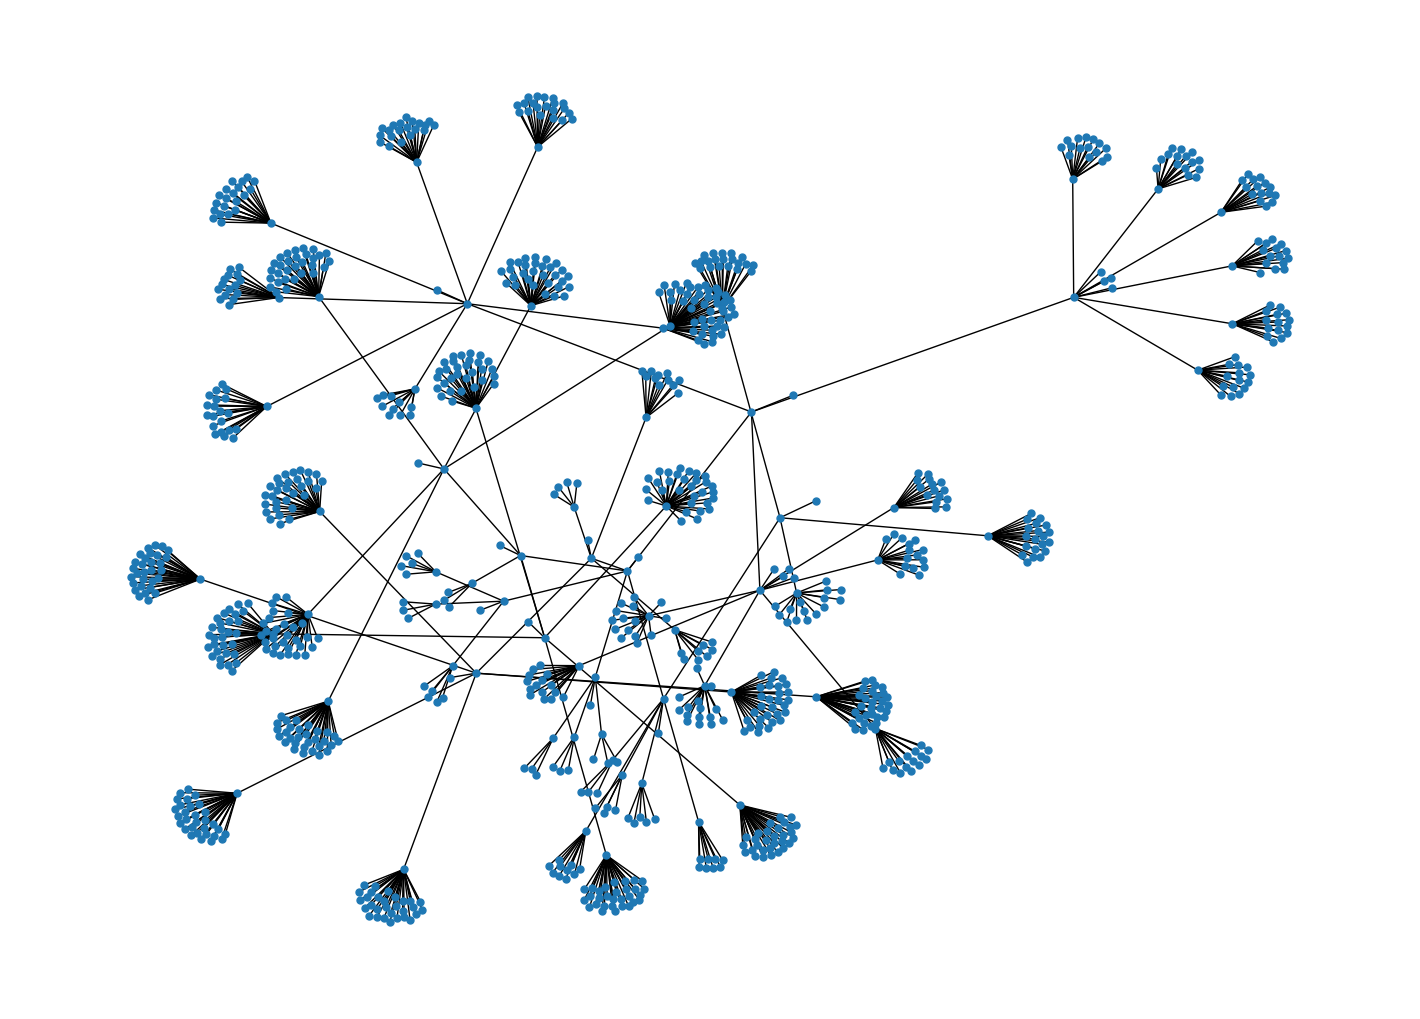

In [14]:
#Represetación gráfica del grafo
plt.figure(figsize=(14, 10))
layout = nx.spring_layout(G1)

nx.draw(G1, pos=layout, with_labels=False, node_size=25, edge_color='black')
plt.savefig('../img/organization_graph.jpg')

plt.show()

In [15]:
print("Nodos G1: ", G1.number_of_nodes())

Nodos G1:  1000


In [16]:
#Guardo el grafo generado
import pickle

with open('../data/graphs/grafo_corporativo.pkl', 'wb') as f:
    pickle.dump(G1, f, pickle.HIGHEST_PROTOCOL)

## 2. Grafo de emails 

El grafo de emails representa las interacciones sociales de los usuarios. Se usará los campos 'from' y los campos 'to', 'cc', 'bcc' para identificar nodos de origen y de destino a la hora de generar las aristas.

In [17]:
email_df = pd.read_csv('../data/email.csv')

In [18]:
email_df.head()

,id,date,user,pc,to,cc,bcc,from,size,attachments,content
0,{R3I7-S4TX96FG-8219JWFF},01/02/2010 07:11:45,LAP0338,PC-5758,Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...,Nathaniel.Hunter.Heath@dtaa.com,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,middle f2 systems 4 july techniques powerful d...
1,{R0R9-E4GL59IK-2907OSWJ},01/02/2010 07:12:16,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,NaN,NaN,MOH68@optonline.net,29942,0,the breaking called allied reservations former...
2,{G2B2-A8XY58CP-2847ZJZL},01/02/2010 07:13:00,LAP0338,PC-5758,Penelope_Colon@netzero.com,NaN,NaN,Lynn_A_Pratt@earthlink.net,28780,0,slowly this uncinus winter beneath addition ex...
3,{A3A9-F4TH89AA-8318GFGK},01/02/2010 07:13:17,LAP0338,PC-5758,Judith_Hayden@comcast.net,NaN,NaN,Lynn_A_Pratt@earthlink.net,21907,0,400 other difficult land cirrocumulus powered ...
4,{E8B7-C8FZ88UF-2946RUQQ},01/02/2010 07:13:28,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,NaN,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,this kmh october holliswood number advised unu...


In [19]:
# Creo un diccionario donde la clave es el 'user' y el valor es un conjunto de sus emails
user_emails_dict = {}

# Itero sobre las filas del DataFrame
for index, row in email_df.iterrows():
    user = row['user']
    email_from = row['from']
    
    # Añado el email 'from'
    if user not in user_emails_dict:
        user_emails_dict[user] = set()
    user_emails_dict[user].add(email_from)

In [20]:
#Genero un grafo tomando como nodos los user_id
G2 = nx.Graph()

for user_id, email in user_emails_dict.items():
    # Agrego el nodo con el user_id y sus emails como atributo
    G2.add_node(user_id, email=email)

print("Número de nodos: {}".format(G2.number_of_nodes()))

Número de nodos: 1000


In [21]:
def generate_vertex_list(email_df):
    """
    Esta función genera los vértices del grafo a partir de los datos de un DataFrame de correos electrónicos.
    """
    vertices = []

    for index, row in email_df.iterrows():
        sender = row['from']  
        recipients = row[['to', 'cc', 'bcc']].str.split(';').explode().dropna().tolist()

        # Genero los vértices
        for recipient in recipients:
            if sender != recipient: #Evito bucles en el grafo.
                vertices.append([sender, recipient])

    return vertices

In [22]:
start_time = time.time()
edges = generate_vertex_list(email_df[['user', 'from', 'to', 'cc', 'bcc']])

In [23]:
#Ejemplo de arista
print(edges[0])

['Lynn.Adena.Pratt@dtaa.com', 'Dean.Flynn.Hines@dtaa.com']


In [24]:
# Lista para almacenar las listas de user_names
vertices_user_names = []

# Itero sobre las listas de vértices
for edge_list in edges:
    # Lista para almacenar los user_names de la lista de vértices actual
    edge_user_names = []
    # Itero sobre los emails en la lista de vértices actual
    for email in edge_list:
        user_name = None
        # Itero sobre las claves y valores del diccionario user_email_dict
        for key, value in user_emails_dict.items():
            if email in value:
                user_name = key
                break
                
        edge_user_names.append(user_name)
    
    # Agrego la lista de user_names a la lista principal
    vertices_user_names.append(edge_user_names)

In [25]:
filtered_edges = [edge for edge in vertices_user_names if None not in edge]

In [26]:
G2.add_edges_from(filtered_edges)
print("Número de aristas: {}".format(G2.number_of_edges()))

Número de aristas: 285011


In [ ]:
end_time = time.time()
execution_time = end_time - start_time
minutes = int(execution_time // 60)
seconds = execution_time % 60
print("Generación de Aristas. Tiempo de Ejecución: {}m {}s".format(minutes, seconds))

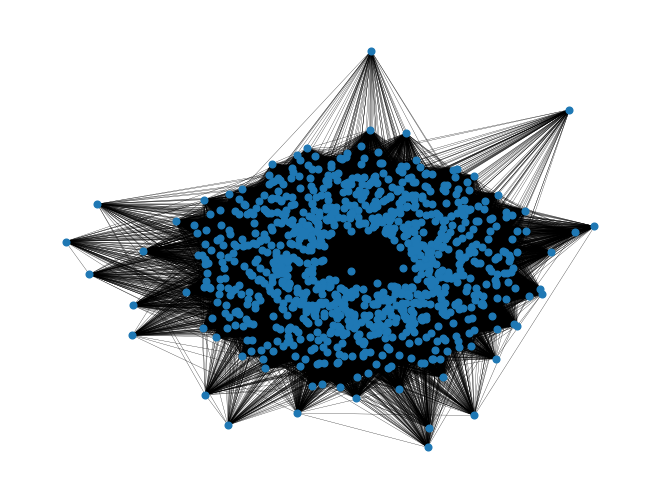

<Figure size 1400x1000 with 0 Axes>

In [27]:
#Represetación gráfica del grafo
layout = nx.spring_layout(G2)

# Dibujar el grafo
nx.draw(G2, pos=layout, with_labels=False, node_size=23, edge_color='black', width=0.2)

plt.figure(figsize=(14, 10))
plt.savefig('../img/email_graph.jpg')

plt.show()

In [28]:
#Exporto el grafo
with open('../data/graphs/grafo_email.pkl', 'wb') as f:
    pickle.dump(G2, f, pickle.HIGHEST_PROTOCOL)

## 2. Grafo combinado

Voy a combinar las aristas de ambos grafos. El objetivo es obtener un grafo denso, y que capture el mayor número de relaciones posibles.

In [29]:
G_merged = G1.copy()
G_merged.add_edges_from(G2.edges() - G1.edges())

In [30]:
print("Número de nodos: {}".format(G_merged.number_of_nodes()))
print("Número de aristas: {}".format(G_merged.number_of_edges()))

Número de nodos: 1000
Número de aristas: 285011


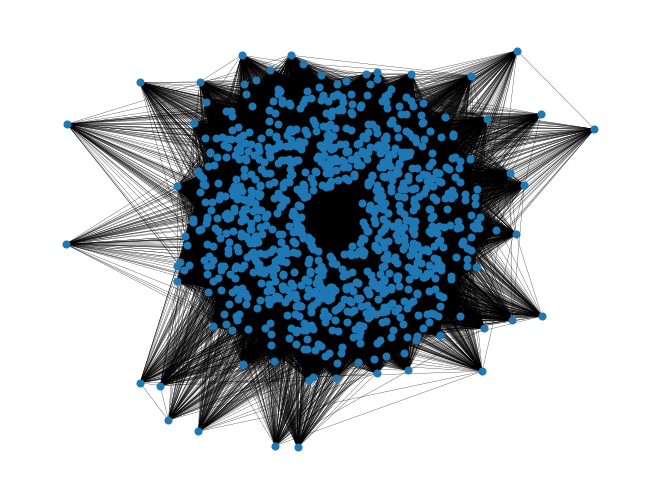

<Figure size 1400x1000 with 0 Axes>

In [31]:
#Represetación gráfica del grafo
layout = nx.spring_layout(G_merged)

# Dibujar el grafo
nx.draw(G_merged, pos=layout, with_labels=False, node_size=23, edge_color='black', width=0.2)

plt.figure(figsize=(14, 10))
plt.savefig('../img/final_graph.jpg')

plt.show()

In [32]:
#Exporto el grafo
with open('../data/graphs/grafo_combinado.pkl', 'wb') as f:
    pickle.dump(G_merged, f, pickle.HIGHEST_PROTOCOL)

## 3. Secuencia de Grados

Comparo los histogramas de secuencia de grados para diferenciar la conectividad de ambos grafos.

In [33]:
#Secuencia de grados
dg_seq1 = [G1.degree(node, weight='weight') for node in G1.nodes()]
dg_seq2 = [G2.degree(node, weight='weight') for node in G2.nodes()]

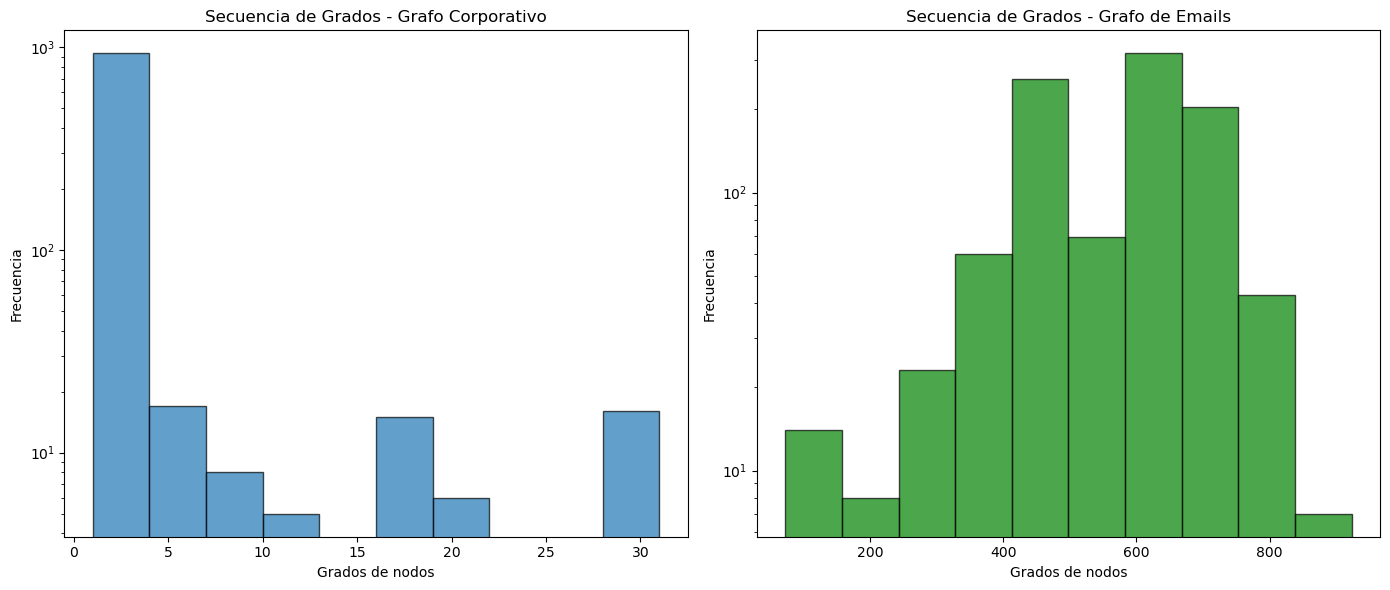

In [34]:
#Histograma - Secuencia de grados
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  

#Grafo Corporativo
axs[0].hist(dg_seq1, alpha=0.7, log=True, edgecolor='black')
axs[0].set_xlabel('Grados de nodos')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Secuencia de Grados - Grafo Corporativo')

#Grafo de Emails
axs[1].hist(dg_seq2, alpha=0.7, log=True, edgecolor='black', color='green')
axs[1].set_xlabel('Grados de nodos')
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Secuencia de Grados - Grafo de Emails')

plt.savefig('../img/degree_seq.jpg')

plt.tight_layout() 
plt.show()